In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



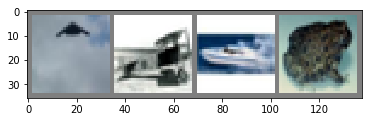

plane plane  ship  frog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.239
[1,  4000] loss: 1.921
[1,  6000] loss: 1.677
[1,  8000] loss: 1.599
[1, 10000] loss: 1.507
[1, 12000] loss: 1.450
[2,  2000] loss: 1.388
[2,  4000] loss: 1.368
[2,  6000] loss: 1.350
[2,  8000] loss: 1.353
[2, 10000] loss: 1.300
[2, 12000] loss: 1.267
Finished Training


Let's quickly save our trained model:



In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

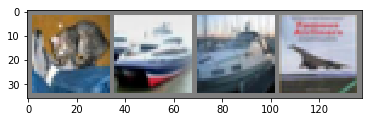

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [14]:
from sklearn.metrics import confusion_matrix 

In [15]:
# https://zhuanlan.zhihu.com/p/73558315
def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):

    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)
    cm1 = plt.cm.get_cmap('RdYlBu')
    # 在混淆矩阵中每格的概率值
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=10, va='center', ha='center')
    
    plt.imshow(cm, interpolation='nearest', cmap=cm1)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    
    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()

Accuracy of plane : 49 %
Accuracy of   car : 75 %
Accuracy of  bird : 30 %
Accuracy of   cat : 23 %
Accuracy of  deer : 51 %
Accuracy of   dog : 55 %
Accuracy of  frog : 66 %
Accuracy of horse : 66 %
Accuracy of  ship : 76 %
Accuracy of truck : 61 %


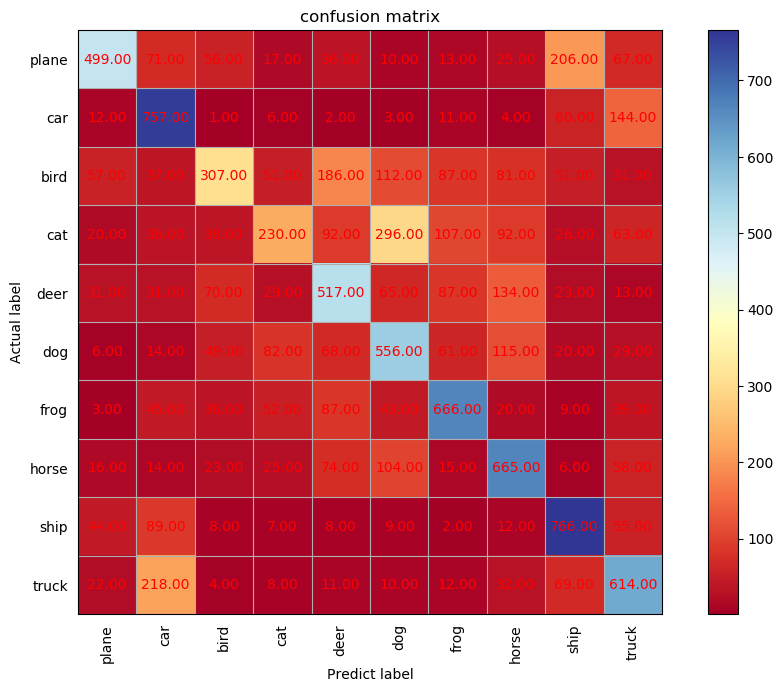

In [16]:
y_true=[]
y_pred=[]
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
#         print(label)
#         print(predicted)
        c = (predicted).squeeze()
        c2 = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            y_true.append(label.numpy())
            y_pred.append(c[i].item())
            class_correct[label] += c2[i].item()
            class_total[label] += 1

# print(y_true)
# print(y_pred)
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

cm=confusion_matrix(y_true,y_pred)
plot_confusion_matrix(cm, 'confusion_matrix.png', title='confusion matrix')

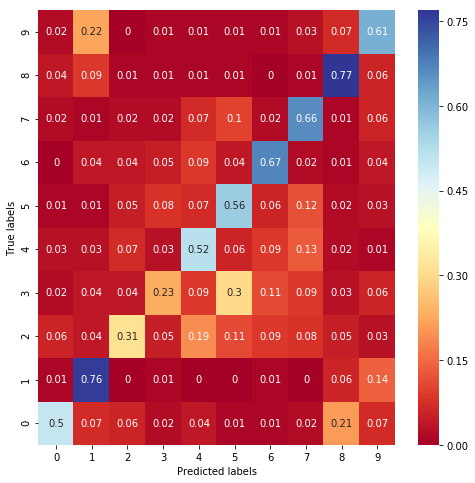

In [17]:
# https://www.dazhuanlan.com/2020/01/30/5e32a6c6c5296/
import seaborn as sns
con_mat=cm
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)

# === plot ===
figure = plt.figure(figsize=(8, 8))
cm = plt.cm.get_cmap('RdYlBu')
sns.heatmap(con_mat_norm, annot=True, cmap=cm)

plt.ylim(0, 10)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()